## Setup

In [21]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpl_patches
from pyhdf.SD import SD, SDC

In [22]:
# directory where your put lib_hdfs
# e.g. /home/tkurihana/src/src_share/lib_hdfs
homedir='/home/rubywerman/scratch-midway2/lib_hdfs'

In [23]:
sys.path.insert(1,os.path.join(sys.path[0],homedir)) # this line helps you to use your own functinos in another directory
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

In [24]:
#returns the coded date in the format of year, and days after January 1st
#e.g. January 1, 2001 -- > 2001015
def get_coded_date(date):
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days_per_month_leap = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    leap_years = [2000, 2004, 2008, 2012]
    year = int(date[0:4])
    month = int(date[5:7])
    day = int(date[8:])
    days = day
    if month != 1:
        calendar = days_per_month
        if year in leap_years:
            calendar = days_per_month_leap
        for m in range(month - 1):
            days += calendar[m]
    return str(year * 1000 + days)

In [25]:
# enter name of text file containing the dates
file_name = "/home/rubywerman/clouds/src_analysis/dates/label1.txt"
text_file = open(file_name, "r")
dates = text_file.read().split('\n')

## Date Selection
Select date from dates list and run the following cells 

In [150]:
selected_date = '2008-04-13'

In [151]:
#select directory path for given date
def get_data(d):
    return (homedir+'/mod02/open_chile_3/' + d, homedir+'/mod35/open_chile_3/' + d, get_coded_date(d))
print("selected date: " + selected_date)
mod02_hdfdir, mod35_hdfdir, date = get_data(selected_date)

selected date: 2008-04-13


## Generate image

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 1


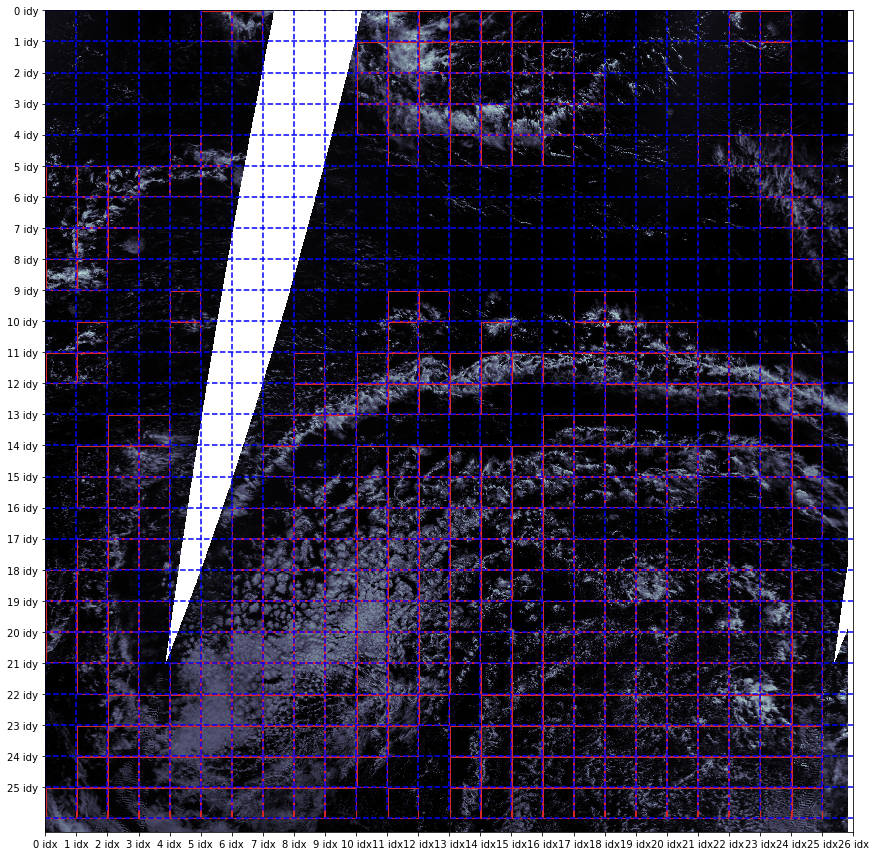

In [152]:
### genetate numpy array for mod02, mod35 data
mod02_img = gen_mod02_img_sigle(hdf_datadir=mod02_hdfdir, date=date)
clouds_mask_img = gen_mod35_img_single(hdf_datadir=mod35_hdfdir, date=date)

# generate patch
## NO normalization to preserve original radiance strength 
mod02_patches = _gen_patches(mod02_img, normalization=False)

# cloud patches with at least ${thres} percent of cloud flag within patch
thres = 0.3 # range [0.0 - 1.0] floating points. 0.3 is optimal
clouds_patches_list, clouds_xy_list = const_clouds_array(mod02_patches, clouds_mask_img, thres=thres)

# reconstruct img array from list
ix, iy = mod02_patches.shape[:2]
cimg_array = np.zeros((ix,iy)).astype(np.float64)
cimg_array[:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy_list):
    cimg_array[x,y] = 0  # input is 0 if there is a cloud (0 corresponds to color-list index afterwords)
    
closed_patches = []
closed_coords = []
open_patches = []
open_coords = []

# load visible band (band 1 out of 36)
hdf_datadir = mod02_hdfdir
vis_file = glob.glob(
        hdf_datadir+'/MOD021KM.A'+date+'.mosaic.061.*.EV_250_Aggr1km_RefSB_1.hdf'
    )[0]

# get hdf data  
vhdf = SD(vis_file, SDC.READ)

# get sds (science data structure) data
vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")

#
vhdf_array, vis_band = mod02_proc_sds_single(vhdf_sds)

fig = plt.figure(figsize=(12,12))

# set params
xmin, ymin = 0, 0
xmax, ymax = vhdf_array.shape
linerange = 1 # every 10 patches, draw line

patches   = mod02_patches
img_array = cimg_array

line_width = 2
SHAPE = 128,128
colors = ['#d62728']  # <-- here number of color-list is just 1 cimg_array[i,j] = {0, nan} 
ax = plt.subplot(1,1,1)
plt.hlines([i for i in range(0,xmax, 128*linerange)], xmin, xmax, "blue", linestyles='dashed')
plt.vlines([i for i in range(0,ymax, 128*linerange)], ymin, ymax, "blue", linestyles='dashed')
plt.imshow(vhdf_array, cmap='bone')
plt.xticks( np.arange(0,xmax,128*linerange), 
           [str(idx*linerange)+' idx' for idx, i in enumerate( np.arange(0,xmax,128*linerange)) ] )
plt.yticks( np.arange(0,ymax,128*linerange), 
           [str(idy*linerange)+' idy' for idy, i in enumerate( np.arange(0,ymax,128*linerange)) ] )

for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        if not np.isnan(img_array[i,j]):
            ax.add_patch(mpl_patches.Rectangle(
                    (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img_array[i,j])],
                      facecolor="none"                 
                    )
            )



fig.tight_layout()
plt.show()

In [153]:
#close_closed_img(selected_date)

In [154]:
#open_closed_img(selected_date)

## Data Collection

In [157]:
def oo(yy1, yy2, xx1, xx2):
    #check if already included in open coords just to prevent adding the same patch twice by accident
    if [yy1, yy2, xx1, xx2] not in open_coords:
        open_coords.append([yy1, yy2, xx1, xx2])
        open_patches.append(_gen_patches(mod02_img[yy1*128:yy2*128, xx1*128:xx2*128], normalization=False))

def cc(yy1, yy2, xx1, xx2):
    #check if already included in closed coords just to prevent adding the same patch twice by accident
    if [yy1, yy2, xx1, xx2] not in closed_coords:
        closed_coords.append([yy1, yy2, xx1, xx2])
        closed_patches.append(_gen_patches(mod02_img[yy1*128:yy2*128, xx1*128:xx2*128], normalization=False))

## Data Output
Be sure to update save path when you switch region (i.e. California to Chile)

In [155]:
#enter the desired save path and cell type 
from tempfile import TemporaryFile
def close_save(selected_date):
    if closed_coords:
        save_path02 = '/home/rubywerman/clouds/src_analysis/close_cells_mod02'
        name_of_file02 = "closed_02_" + selected_date
        completeName02 = os.path.join(save_path02, name_of_file02)  
        np.save(completeName02, closed_patches)
        outfile02 = TemporaryFile()
        np.save(outfile02, closed_patches)
        
        
def open_save(selected_date):
    if open_coords:
        save_path02 = '/home/rubywerman/clouds/src_analysis/open_cells_mod02'
        name_of_file02 = "open_02_" + selected_date
        completeName02 = os.path.join(save_path02, name_of_file02)  
        np.save(completeName02, open_patches)
        outfile02 = TemporaryFile()
        np.save(outfile02, open_patches)

        
def close_closed_img(selected_date):
        save_path35 = '/home/rubywerman/clouds/src_analysis/close_cells_mod35'
        name_of_file35 = "closed_35_" + selected_date
        completeName35 = os.path.join(save_path35, name_of_file35)  
        np.save(completeName35, clouds_mask_img)
        outfile35 = TemporaryFile()
        np.save(outfile35, clouds_mask_img)

def open_closed_img(selected_date):
        save_path35 = '/home/rubywerman/clouds/src_analysis/open_cells_mod35'
        name_of_file35 = "open_35_" + selected_date
        completeName35 = os.path.join(save_path35, name_of_file35)  
        np.save(completeName35, clouds_mask_img)
        outfile35 = TemporaryFile()
        np.save(outfile35, clouds_mask_img)
    
def bad_data(selected_date):
    save_path = '/Users/rubywerman/desktop/clouds/src_shared/lib_hdfs/chile'
    name_of_file = "bad-data"
    completeName = os.path.join(save_path, name_of_file+".txt")
    file = open(completeName, "a")
    file.write(selected_date + "\n")
def oob_data(selected_date):
    save_path = '/Users/rubywerman/desktop/clouds/src_shared/lib_hdfs/chile'
    name_of_file = "out-of-bounds-data"
    completeName = os.path.join(save_path, name_of_file+".txt")
    file = open(completeName, "a")
    file.write(selected_date + "\n")

# Run the cells you need below to export data

### Report bad data

In [238]:
bad_data(selected_date)

### Report out of bounds data

In [477]:
oob_data(selected_date)

### Report closed cell data

In [266]:
close_save(selected_date)

### Report open cell data

In [267]:
open_save(selected_date)